The examples below assume that we have installed the package _genephys_ from PyPi. The examples follow the experiments from <a href="www.bioarxiv" > Vidaurre (2023)</a>, where the mathematical specification of the model can be found. 

In all the examples, we will be generating data with _N_=250 trials, _T_=400 time points per trial and _nchan_=64 channels. Frequency here refers to angular frequency; to obtain the ordinary frequency we just need to multiply by $\frac{F}{2 \pi}$, where $F$ is the sampling frequency in Hz. 

We first generate some spontaneous activity, with time-varying frequency in the range [0.15, 0.15 $\pi$] and time-varying amplitude in the range [0.8,1.2]. Here, amplitude is just a multiplying factor on the signal; for example, a sinusoid taking values in [-1,1], when multiplied by an amplitude factor of 2.0, would take values in [-2,2]. 

In [21]:
# Basic imports and variable setting

import sampler,decoders,graphics
import math
import numpy as np

N,T,nchan = 250,400,64
Q = 2 # two classes

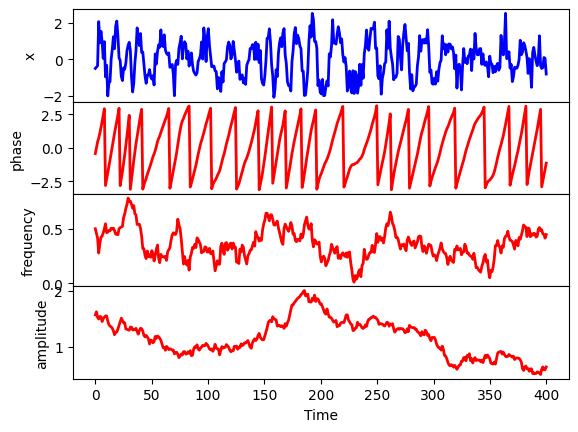

In [2]:
# evoked_options_empty contains the parameters regarding stimulation;
# we set all the types of effect to False since this is spontaneous activity under no stimulation
evoked_options_empty = {"phase_reset": False, "amplitude_modulation": 
    False, "additive_response": False, "additive_oscillation": False}
# spont_options contains the parameters regarding spontaneous activity; 
# we just specify the ranges of angular frequency and amplitude 
spont_options = {"FREQ_RANGE": [0.01, math.pi/4], "AMP_RANGE": [0.5, 2]}

# We create the DataSampler object; 
# the third parameter is the number of types of stimuli; we specify None 
ds_rest = sampler.DataSampler(T,nchan,None,spont_options,evoked_options_empty)

# We sample N "trials"
(X,Phase,Freq,Amplitude,_,_) = ds_rest.sample(N)

# Plot the signal
graphics.plot_signal(X,Phase,Freq,Amplitude,None,None,0,0)

As a sanity check, we separately generate a stimulus time series and try to decode it from the spontaneous signal. As it should be, decoding accuracy fluctuates randomly around baseline. 


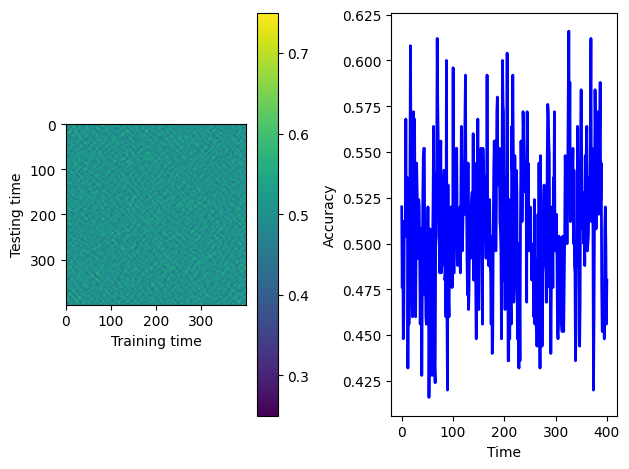

In [3]:
Stim = ds_rest.sample_stimulus(N,2,T)
decoder = decoders.Decoder(classification=True)
accuracy, betas = decoder.decode(X,Stim)
graphics.plot_accuracy(accuracy)

Now, let's generate data where a two-class stimulation is presented. Here, we have a phase-resetting effect on two relevant channels, while the others don't respond. These two channels reset to stimulus-specific phase $\psi^k$ in a quite consistent manner (i.e. they have some phase noise that is sampled from a von Mises distribution with low standard deviation $\sigma_{\psi}$)


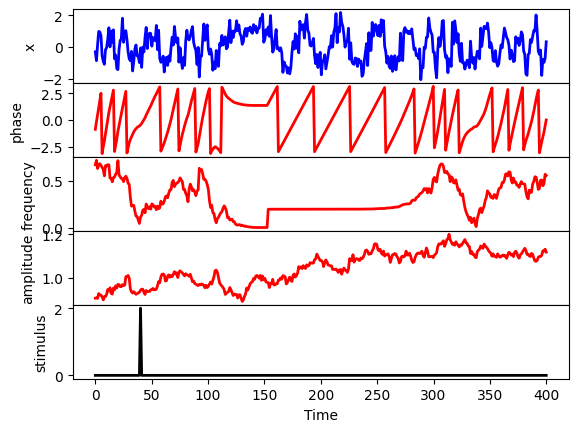

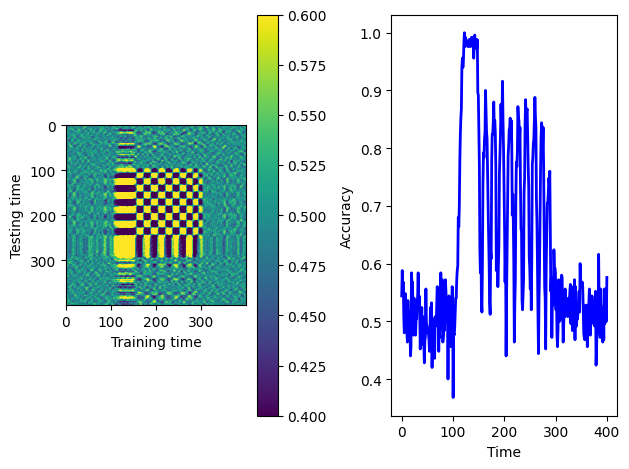

In [4]:
# Channel probability is 0.0 except for the first two relevant channels, where it is 1.0
chan_prob = np.zeros((nchan,))
chan_prob[0:2] = 1.0 
# Standard deviation for the phase distribution
std_ph = 0.1 * math.pi

spont_options = {"FREQ_RANGE": [0.01, math.pi/4], "AMP_RANGE": [0.8, 1.2]}

evoked_options = {"phase_reset": True, "amplitude_modulation": False, 
    "additive_response": False, "additive_oscillation": False,
    "CHAN_PROB": chan_prob,
    "STD_PH": std_ph
    }

ds_task = sampler.DataSampler(T,nchan,Q,spont_options,evoked_options)
(X,Phase,Freq,Amplitude,_,Stim) = ds_task.sample(N)

decoder = decoders.Decoder(classification=True)
accuracy, betas = decoder.decode(X,Stim)

# Plot the signal
graphics.plot_signal(X,Phase,Freq,Amplitude,None,Stim,2,0)

# Plot the accuracy
graphics.plot_accuracy(accuracy,(0.4,0.6))

As we see, while the diagonal of the TGM is plausible, the TGM itself has a chequered pattern we don't see in real data. In contrast, as we see below, making channel responses stochastic (by setting a probability of responding per channel of $\theta=1/8$), produces much more realistic results. 

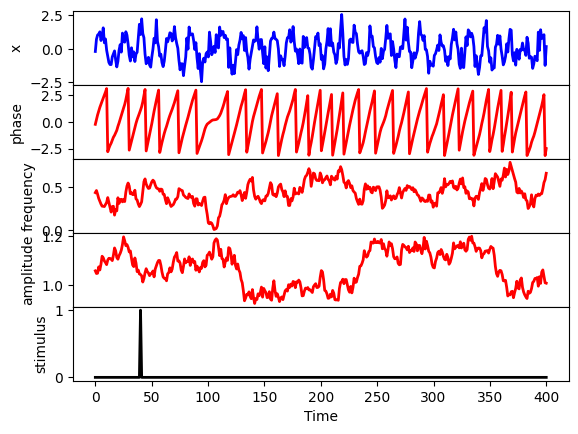

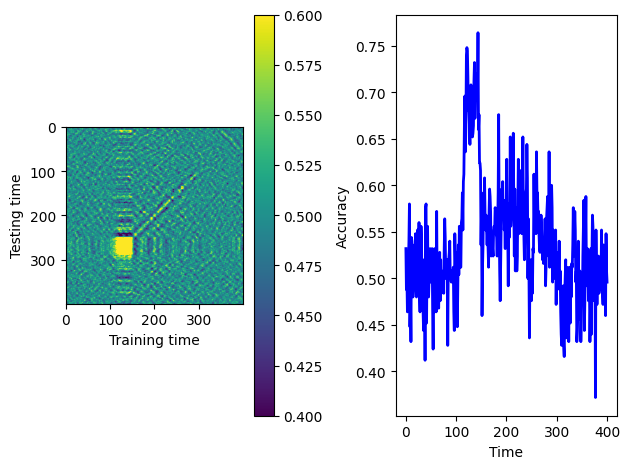

In [5]:
# Channel probability is 1/8 for half of the channels, the rest are irrelevant
chan_prob = np.zeros((nchan,))
chan_prob[0:31] = 1/8
# Standard deviation for the phase distribution 
std_ph = 0.1 * math.pi

spont_options = {"FREQ_RANGE": [0.01, math.pi/4], "AMP_RANGE": [0.8, 1.2]}

evoked_options = {"phase_reset": True, "amplitude_modulation": False,
    "additive_response": False, "additive_oscillation": False,
    "CHAN_PROB": chan_prob,
    "STD_PH": std_ph
    }

ds_task = sampler.DataSampler(T,nchan,Q,spont_options,evoked_options)
(X,Phase,Freq,Amplitude,_,Stim) = ds_task.sample(N)

decoder = decoders.Decoder(classification=True)
accuracy, betas = decoder.decode(X,Stim)

# Plot the signal
graphics.plot_signal(X,Phase,Freq,Amplitude,None,Stim,0,0)

# Plot the accuracy
graphics.plot_accuracy(accuracy,(0.4,0.6))

We now simulate another type of phase reset stochasticity. While keeping the probability of responding $\theta$ for all channels equal to 1.0, we increase the noise $\sigma_{\psi}$ of the phase distribution (at which the signals reset), and repeat the experiment.

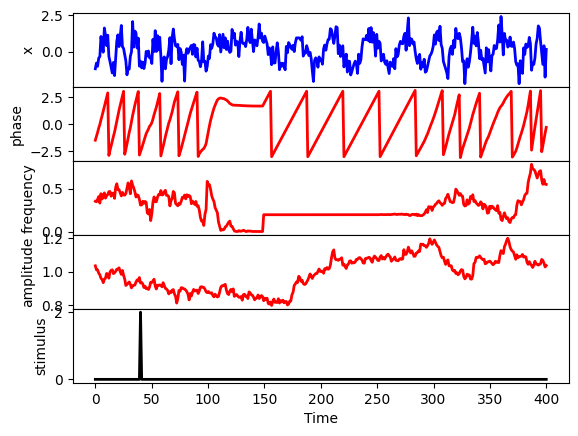

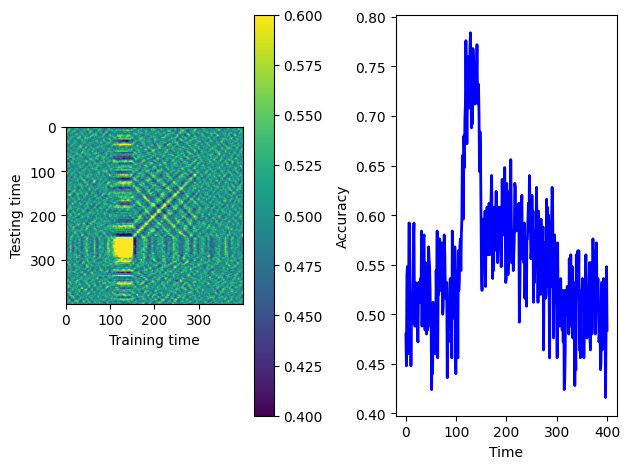

In [6]:
# Channel probability is 1.0 for half of the channels, the rest are irrelevant
chan_prob = np.zeros((nchan,))
chan_prob[0:31] = 1.0
# Standard deviation for the phase distribution is much higher than in previous examples
std_ph = 0.6 * math.pi

spont_options = {"FREQ_RANGE": [0.01, math.pi/4], "AMP_RANGE": [0.8, 1.2]}

evoked_options = {"phase_reset": True, "amplitude_modulation": False, 
    "additive_response": False, "additive_oscillation": False,
    "CHAN_PROB": chan_prob,
    "STD_PH": std_ph
    }

ds_task = sampler.DataSampler(T,nchan,Q,spont_options,evoked_options)
(X,Phase,Freq,Amplitude,_,Stim) = ds_task.sample(N)

decoder = decoders.Decoder(classification=True)
accuracy, betas = decoder.decode(X,Stim)

# Plot the signal
graphics.plot_signal(X,Phase,Freq,Amplitude,None,Stim,0,0)

# Plot the accuracy
graphics.plot_accuracy(accuracy,(0.4,0.6))

Next, we simulate yet another type of phase reset stochasticity. While keeping $\theta=1.0$ and $\sigma_{\psi}$ low, we vary the variability of the latency of the responses. That is, the phase at which the channels reset is stable, but there is a lot of variability on when do they respond. We will see that the pattern of decoding changes to something less realistic. 


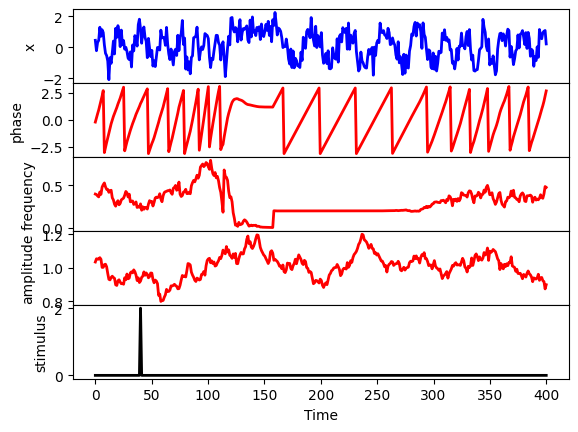

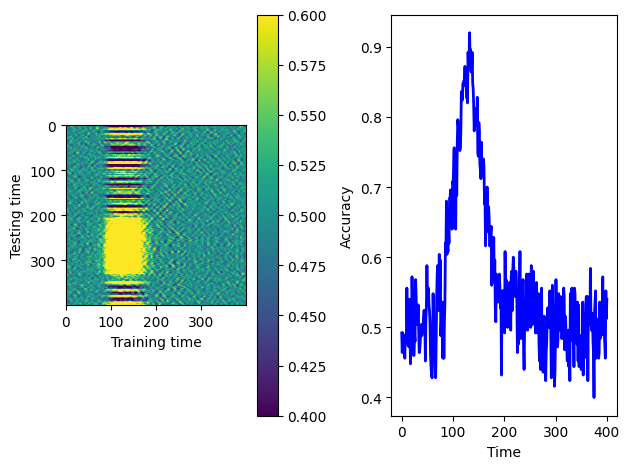

In [7]:
# Channel probability is 1.0 for half of the channels, the rest are irrelevant
chan_prob = np.zeros((nchan,))
chan_prob[0:31] = 1.0
# Standard deviation for the phase distribution is low
std_ph = 0.1 * math.pi
# Latency of responses is high (by default this parameter is 0.0)
DELAY_ABSOLUTE_JITTER = 25

spont_options = {"FREQ_RANGE": [0.01, math.pi/4], "AMP_RANGE": [0.8, 1.2]}

evoked_options = {"phase_reset": True, "amplitude_modulation": False, 
    "additive_response": False, "additive_oscillation": False,
    "CHAN_PROB": chan_prob,
    "STD_PH": std_ph,
    "DELAY_ABSOLUTE_JITTER": DELAY_ABSOLUTE_JITTER
    }

ds_task = sampler.DataSampler(T,nchan,Q,spont_options,evoked_options)
(X,Phase,Freq,Amplitude,_,Stim) = ds_task.sample(N)

decoder = decoders.Decoder(classification=True)
accuracy, betas = decoder.decode(X,Stim)

# Plot the signal
graphics.plot_signal(X,Phase,Freq,Amplitude,None,Stim,0,0)

# Plot the accuracy
graphics.plot_accuracy(accuracy,(0.4,0.6))

In the previous cell, all channels have the same delay (i.e. an absolute delay). Alternatively, we can have different delays for different channels within a given trial (i.e. a relative delay).

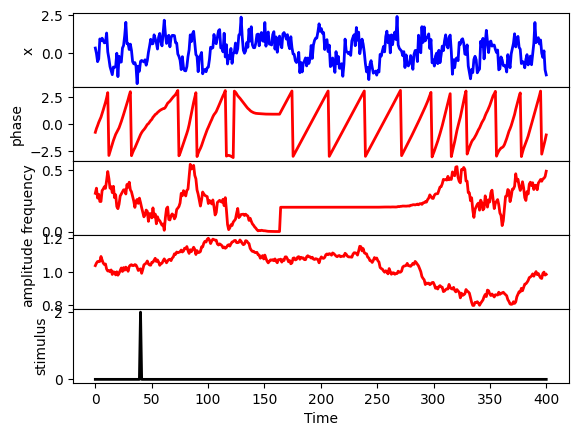

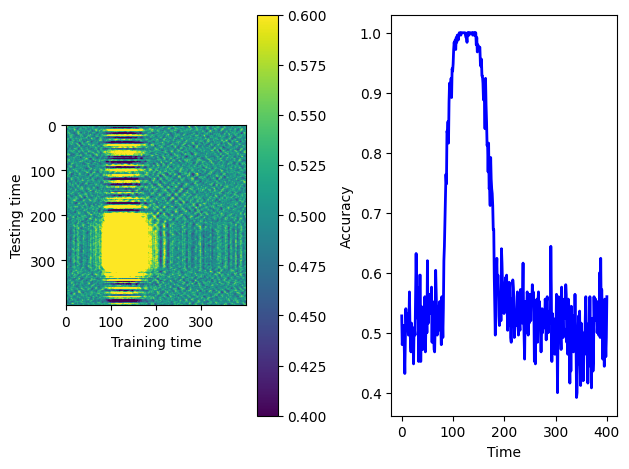

In [8]:
# Channel probability is 1.0 for half of the channels, the rest are irrelevant
chan_prob = np.zeros((nchan,))
chan_prob[0:31] = 1.0
# Standard deviation for the phase distribution is low
std_ph = 0.1 * math.pi
# Latency of responses is high (by default this parameter is 0.0)
DELAY_ABSOLUTE_JITTER = 0
DELAY_JITTER = 25.0

spont_options = {"FREQ_RANGE": [0.01, math.pi/4], "AMP_RANGE": [0.8, 1.2]}

evoked_options = {"phase_reset": True, "amplitude_modulation": False, 
    "additive_response": False, "additive_oscillation": False,
    "CHAN_PROB": chan_prob,
    "STD_PH": std_ph,
    "DELAY_ABSOLUTE_JITTER": DELAY_ABSOLUTE_JITTER,
    "DELAY_JITTER": DELAY_JITTER,
    }

ds_task = sampler.DataSampler(T,nchan,Q,spont_options,evoked_options)
(X,Phase,Freq,Amplitude,_,Stim) = ds_task.sample(N)

decoder = decoders.Decoder(classification=True)
accuracy, betas = decoder.decode(X,Stim)

# Plot the signal
graphics.plot_signal(X,Phase,Freq,Amplitude,None,Stim,0,0)

# Plot the accuracy
graphics.plot_accuracy(accuracy,(0.4,0.6))

Next we will investigate three different possibilities for frequency entrainment.  All frequencies are given in angular frequency.  

- All channels entrain to the same frequency.
- Channels entrain to one of three frequencies: 0.15, 0.30 and 0.45.
- Every channel entrains at a different frequency, which can take any value between 0.15 and 0.45.


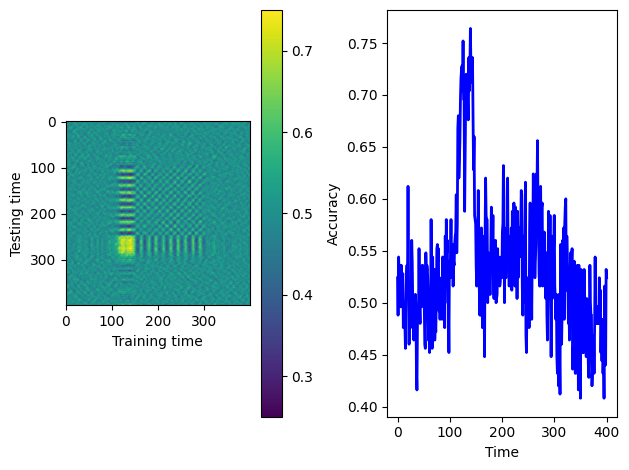

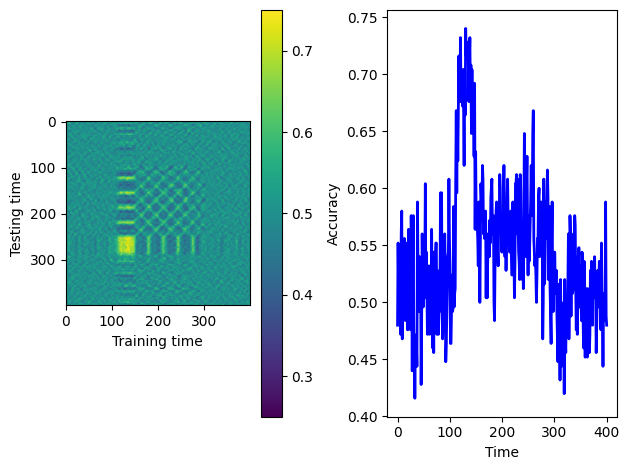

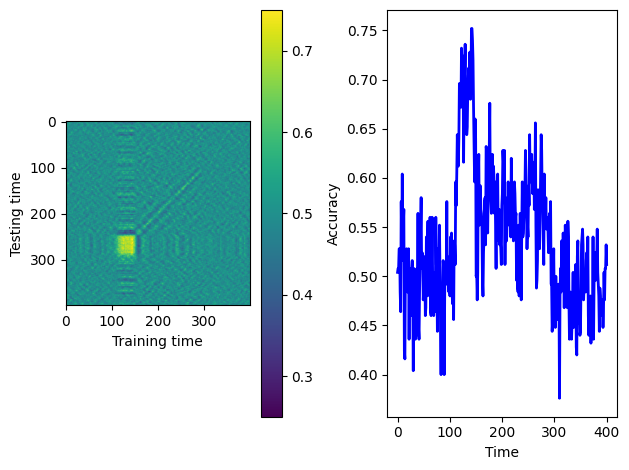

In [9]:
# Channel probability is 1/8 for half of the channels, the rest are irrelevant
chan_prob = np.zeros((nchan,))
chan_prob[0:31] = 1/8
# Standard deviation for the phase distribution 
std_ph = 0.1 * math.pi

spont_options = {"FREQ_RANGE": [0.01, math.pi/4], "AMP_RANGE": [0.8, 1.2]}

accuracies = np.zeros((T,T,4))
evoked_options = {"phase_reset": True, "amplitude_modulation": False, 
    "additive_response": False, "additive_oscillation": False,
    "CHAN_PROB": chan_prob,
    "STD_PH": std_ph
    }

# one frequency 
evoked_options["FREQUENCIES_ENTRAINMENT"] = 1
evoked_options["ENTRAINMENT_REGIME"] = 'linear'
ds_task = sampler.DataSampler(T,nchan,Q,spont_options,evoked_options)
(X,Phase,Freq,Amplitude,_,Stim) = ds_task.sample(N)
decoder = decoders.Decoder(classification=True)
accuracies[:,:,0],_ = decoder.decode(X,Stim)

# three frequencies 
evoked_options["FREQUENCIES_ENTRAINMENT"] = 3 # could also specify them manually as a tuple
evoked_options["ENTRAINMENT_REGIME"] = 'linear'
ds_task = sampler.DataSampler(T,nchan,Q,spont_options,evoked_options)
(X,Phase,Freq,Amplitude,_,Stim) = ds_task.sample(N)
decoder = decoders.Decoder(classification=True)
accuracies[:,:,1],_ = decoder.decode(X,Stim)

# multiple frequencies
evoked_options["FREQUENCIES_ENTRAINMENT"] = 0
evoked_options["ENTRAINMENT_REGIME"] = 'linear'
ds_task = sampler.DataSampler(T,nchan,Q,spont_options,evoked_options)
(X,Phase,Freq,Amplitude,_,Stim) = ds_task.sample(N)
decoder = decoders.Decoder(classification=True)
accuracies[:,:,2],_ = decoder.decode(X,Stim)

graphics.plot_accuracy(accuracies[:,:,0],colorbar_accuracy_lim=(0.25,0.75))
graphics.plot_accuracy(accuracies[:,:,1],colorbar_accuracy_lim=(0.25,0.75))
graphics.plot_accuracy(accuracies[:,:,2],colorbar_accuracy_lim=(0.25,0.75))


In the previous cell, all entrainment frequencies are linear; that is they are described by perfect sinusoids. We can also have entrainment based on instantaneous frequency that varies dynamically. 
In this case, at the very start of the entrainment (i.e. right after phase resetting is complete), the entrainment frequency is defined as before; but then evolves according to a Gaussian walk. 

In the next cell we generate data with a nonlinear entrainment and run the decoding as before. We also show an example of the time series, to be compared to the time series shown above. 



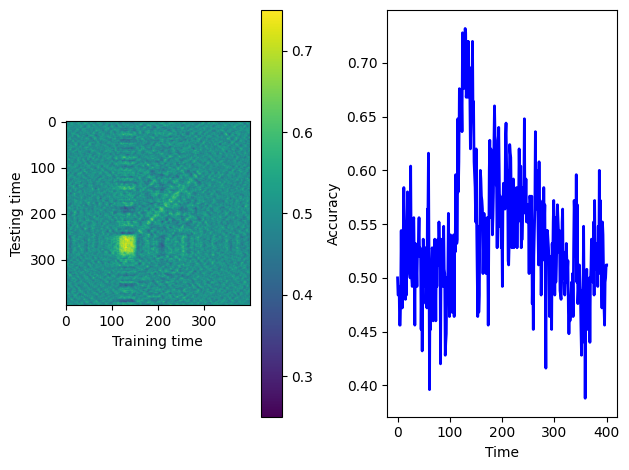

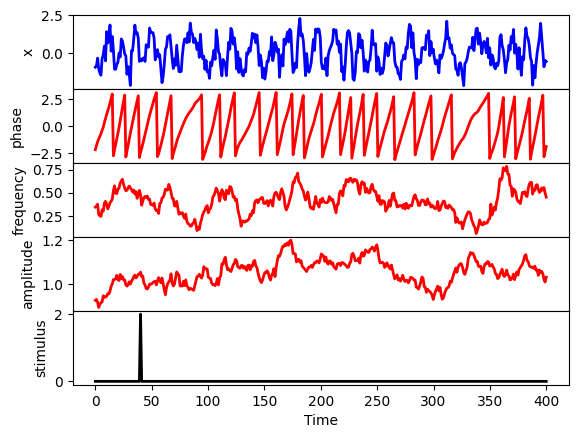

In [10]:
# multiple frequencies - non regular phase progression (non-sinusoidal)
evoked_options["FREQUENCIES_ENTRAINMENT"] = 0
evoked_options["ENTRAINMENT_REGIME"] = 'nonlinear'
ds_task = sampler.DataSampler(T,nchan,Q,spont_options,evoked_options)
(X,Phase,Freq,Amplitude,_,Stim) = ds_task.sample(N)
decoder = decoders.Decoder(classification=True)
accuracy,_ = decoder.decode(X,Stim)

graphics.plot_accuracy(accuracy,colorbar_accuracy_lim=(0.25,0.75))
graphics.plot_signal(X,Phase,Freq,Amplitude,None,Stim,0,0)


We will now assess the effect of an amplitude enhancement of the ongoing oscillation, accompaning phase resetting. We will use the same configuration from a previous cell where there was no amplitude increases, showing the two simulations side by side. 

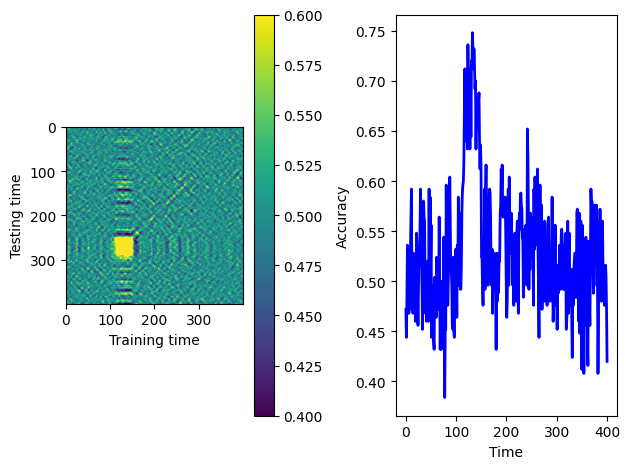

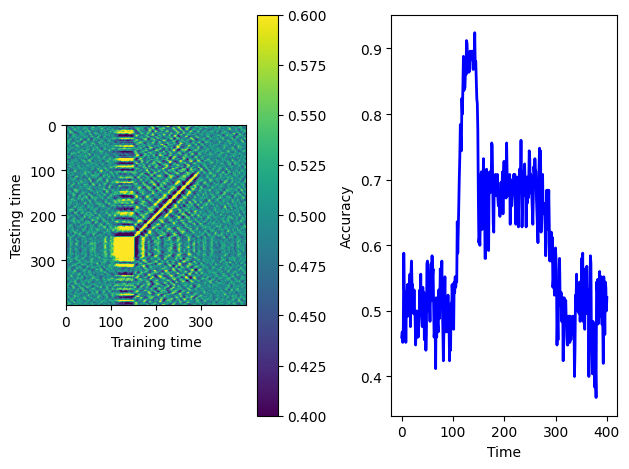

In [11]:
# Channel probability is 1/8 for half of the channels, the rest are irrelevant
chan_prob = np.zeros((nchan,))
chan_prob[0:31] = 1/8
# Standard deviation for the phase distribution 
std_ph = 0.1 * math.pi

spont_options = {"FREQ_RANGE": [0.01, math.pi/4], "AMP_RANGE": [0.8, 1.2]}

evoked_options = {"phase_reset": True, "amplitude_modulation": False, 
    "additive_response": False, "additive_oscillation": False,
    "CHAN_PROB": chan_prob,
    "STD_PH": std_ph
    }

ds_task = sampler.DataSampler(T,nchan,Q,spont_options,evoked_options)
(X,Phase,Freq,Amplitude,_,Stim) = ds_task.sample(N)

decoder = decoders.Decoder(classification=True)
accuracy1, _ = decoder.decode(X,Stim)


evoked_options = {"phase_reset": True, "amplitude_modulation": True, 
    "additive_response": False, "additive_oscillation": False,
    "CHAN_PROB": chan_prob,
    "STD_PH": std_ph,
    "AMP": 2.0
    }

ds_task = sampler.DataSampler(T,nchan,Q,spont_options,evoked_options)
(X,Phase,Freq,Amplitude,_,Stim) = ds_task.sample(N)

decoder = decoders.Decoder(classification=True)
accuracy2, _ = decoder.decode(X,Stim)


# Plot the accuracies
graphics.plot_accuracy(accuracy1,(0.4,0.6))
graphics.plot_accuracy(accuracy2,(0.4,0.6))

We will now test the effect of an additive, non-oscillatory response on top of the phase reset. We will see that the spread of decoding accuracy resembles what we often see in real data. 

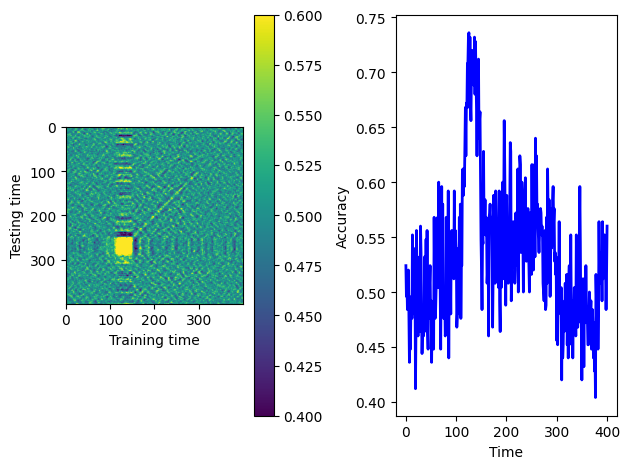

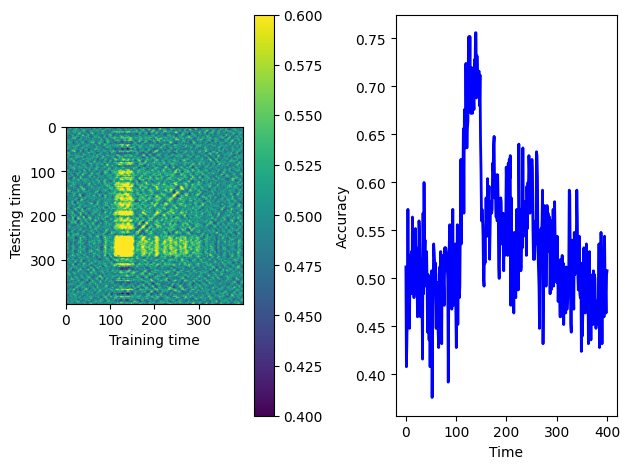

In [12]:
# Channel probability is 1/8 for half of the channels, the rest are irrelevant
chan_prob = np.zeros((nchan,))
chan_prob[0:31] = 1/8
# Standard deviation for the phase distribution 
std_ph = 0.1 * math.pi

spont_options = {"FREQ_RANGE": [0.01, math.pi/4], "AMP_RANGE": [0.8, 1.2]}

evoked_options = {"phase_reset": True, "amplitude_modulation": False,
    "additive_response": False, "additive_oscillation": False,
    "CHAN_PROB": chan_prob,
    "STD_PH": std_ph
    }

ds_task = sampler.DataSampler(T,nchan,Q,spont_options,evoked_options)
(X,Phase,Freq,Amplitude,_,Stim) = ds_task.sample(N)

decoder = decoders.Decoder(classification=True)
accuracy1, _ = decoder.decode(X,Stim)


evoked_options = {"phase_reset": True, "amplitude_modulation": False, 
    "additive_response": True, "additive_oscillation": False,
    "CHAN_PROB": chan_prob,
    "STD_PH": std_ph,
    "DIFF_ADDR": 0.5,
    "STD_ADDR": 0.5
    }

ds_task = sampler.DataSampler(T,nchan,Q,spont_options,evoked_options)
(X,Phase,Freq,Amplitude,_,Stim) = ds_task.sample(N)

decoder = decoders.Decoder(classification=True)
accuracy2, _ = decoder.decode(X,Stim)


# Plot the accuracies
graphics.plot_accuracy(accuracy1,(0.4,0.6))
graphics.plot_accuracy(accuracy2,(0.4,0.6))

We can also look at the effect of having an additive oscillatory response. The resulting patterns are clearly different from the previous configurations. 

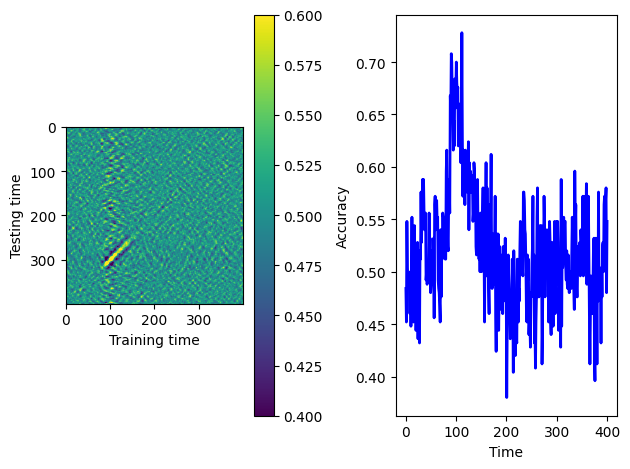

In [20]:
# Channel probability is 1/8 for half of the channels, the rest are irrelevant
chan_prob = np.zeros((nchan,))
chan_prob[0:31] = 1/8
# Standard deviation for the phase distribution 
std_ph = 0.1 * math.pi

ADDOP = np.zeros((Q,nchan))
ADDOP[0,:] = -20
ADDOP[1,:] = +20
ADDOF = np.zeros((Q,nchan))
ADDOF[0:,] = 0.6 * np.linspace(0.25,0.75,nchan) * math.pi/4
ADDOF[1:,] = 0.6 * np.linspace(0.25,0.75,nchan) * math.pi/4

spont_options = {"FREQ_RANGE": [0.01, math.pi/4], "AMP_RANGE": [0.8, 1.2]}

evoked_options = {"phase_reset": False, "amplitude_modulation": False,
    "additive_response": False, "additive_oscillation": True,
    "CHAN_PROB": chan_prob,
    "ADDOP": ADDOP, "STD_ADDOP": 0.01,
    "ADDOF": ADDOF, "STD_ADDOF": 0.01,
    "ADDOA": 2, "STD_ADDOF": 0.01,
    "KERNEL_PAR" : ('Exponential','Log') , "KERNEL_PAR" : (25,(2,150,0))
    }

ds_task = sampler.DataSampler(T,nchan,Q,spont_options,evoked_options)
(X,Phase,Freq,Amplitude,_,Stim) = ds_task.sample(N)

decoder = decoders.Decoder(classification=True)
accuracy1, _ = decoder.decode(X,Stim)

# Plot the accuracies
graphics.plot_accuracy(accuracy1,(0.4,0.6))


As a sanity check, we project the data into a higher dimensional space, which 
we can think of sensor space, and repeat the decoding. It gives comparable results. 

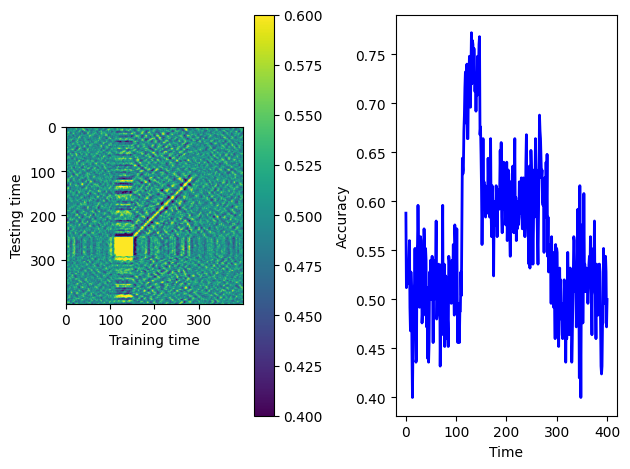

In [18]:

# Channel probability is 1/8 for half of the channels, the rest are irrelevant
chan_prob = np.zeros((nchan,))
chan_prob[0:31] = 1/8
# Standard deviation for the phase distribution 
std_ph = 0.1 * math.pi

spont_options = {"FREQ_RANGE": [0.01, math.pi/4], "AMP_RANGE": [0.8, 1.2]}

evoked_options = {"phase_reset": True, "amplitude_modulation": False,
    "additive_response": False, "additive_oscillation": False,
    "CHAN_PROB": chan_prob,
    "STD_PH": std_ph
    }

ds_task = sampler.DataSampler(T,nchan,Q,spont_options,evoked_options)
(X,Phase,Freq,Amplitude,_,Stim) = ds_task.sample(N)

head_model = np.random.random((nchan,nchan*2))
X_s = ds_task.project(X,head_model)
decoder = decoders.Decoder(classification=True)
accuracy3, _ = decoder.decode(X_s,Stim)
graphics.plot_accuracy(accuracy3,(0.4,0.6))


Finally, let's look at a few activation functions:

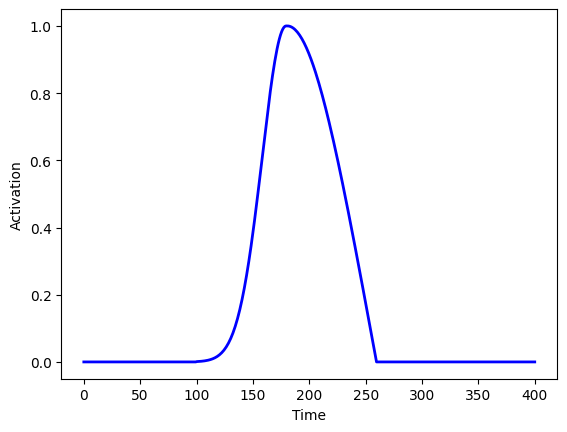

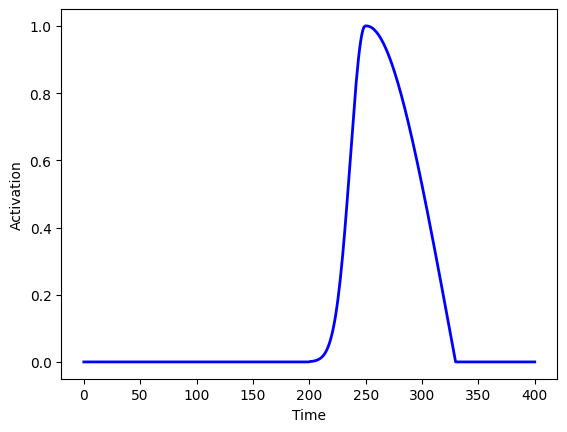

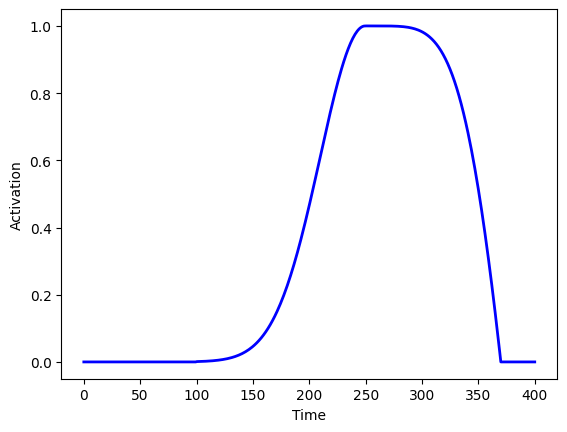

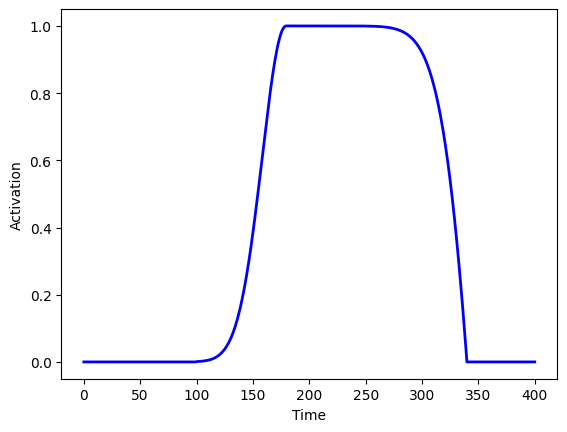

In [14]:
import graphics

T = 400

graphics.plot_activation_function(kernel_par=(80,(2,80,0),0),T=400)
graphics.plot_activation_function(kernel_par=(50,(2,80,0),100),T=400)
graphics.plot_activation_function(kernel_par=(150,(5,120,0)),T=400)
graphics.plot_activation_function(kernel_par=(80, (10, 160, 0)),T=400)
